# Building and training a pretrained AlexNet on ImageNet

Setup: https://course.fast.ai/start_colab.html

500 image MNIST dataset which is structured as:
80% train
10% valid
10% test

Notes:


1.   Transfer Learning (freeze and unfreeze)
2.   CNN
3.   CLR
4.   Data Aug




In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fastai.vision import *
from fastai.gen_doc.nbdoc import *
from fastai.callbacks import *
from fastai.callbacks.hooks import *
from fastai.metrics import Precision, Recall, error_rate

import os

In [3]:
from google.colab import drive

path = untar_data(URLs.MNIST); path

drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Mounted at /content/gdrive


In [0]:
tfms = get_transforms(do_flip=False, max_lighting=None, max_zoom=1.2, p_affine=0.5, max_warp=0.2, max_rotate=5.0)

In [0]:
LIMIT_DS = 500
TRAIN_DS_PCT = 0.8
VALID_DS_PCT = 0.1
TEST_DS_PCT = 0.1

TRAINING_DS_SIZE = 63000

In [0]:
train_sz = (LIMIT_DS*TRAIN_DS_PCT)/TRAINING_DS_SIZE
valid_sz = (LIMIT_DS*VALID_DS_PCT)/TRAINING_DS_SIZE
sd_train = ImageList.from_folder(path/'training').split_subsets(train_size=train_sz,valid_size=valid_sz,seed=8080)
ll_train = sd_train.label_from_folder();
data = ImageDataBunch.create_from_ll(ll_train,ds_tfms=tfms, size=28, bs=32).normalize(imagenet_stats)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
380 47


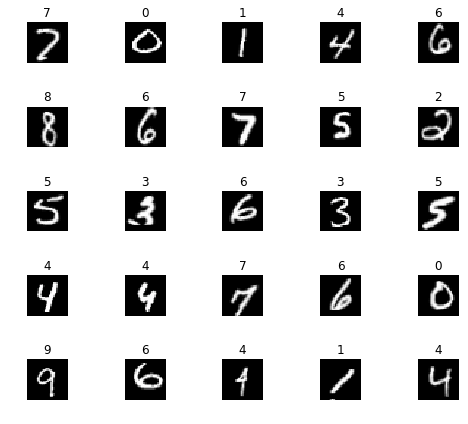

In [12]:
print(data.classes)
print(len(data.train_ds),len(data.valid_ds))
data.show_batch(rows=5, figsize=(7,6))

In [15]:
learn = cnn_learner(data,models.vgg16_bn,metrics=[accuracy,error_rate,Precision(),Recall(),FBeta(beta=1),MatthewsCorreff()],model_dir=base_dir+"/tmp/models")

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 553507836/553507836 [00:28<00:00, 19588762.17it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


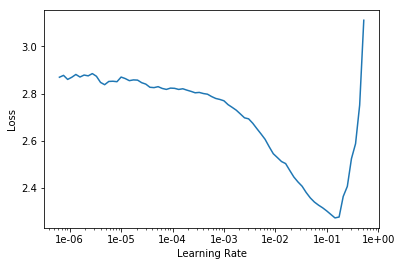

In [16]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-02

In [18]:
learn.fit_one_cycle(100,slice(lr))

epoch,train_loss,valid_loss,accuracy,error_rate,precision,recall,f_beta,matthews_correff,time
0,2.633347,2.301267,0.085106,0.914894,nan,0.106667,0.031385,-0.004429,00:01
1,2.436138,2.222206,0.148936,0.851064,nan,0.133333,0.000000,0.056464,00:00
2,2.319188,2.024887,0.297872,0.702128,0.298246,0.265952,0.281175,0.224973,00:00
3,2.188052,1.956048,0.361702,0.638298,0.353651,0.356190,0.354916,0.294582,00:00
4,2.073598,1.963334,0.446809,0.553191,0.461429,0.434524,0.447572,0.392947,00:00
5,1.977206,1.919852,0.446809,0.553191,0.447222,0.439524,0.443340,0.394068,00:00
6,1.901410,1.851569,0.531915,0.468085,0.473333,0.504762,0.488543,0.481592,00:00
7,1.786350,1.774721,0.489362,0.510638,nan,0.479524,0.000000,0.436454,00:00
8,1.684196,1.722870,0.553191,0.446809,nan,0.541429,0.000000,0.506681,00:00
9,1.620411,1.606464,0.553191,0.446809,nan,0.532381,0.000000,0.512894,00:00


/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:186: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


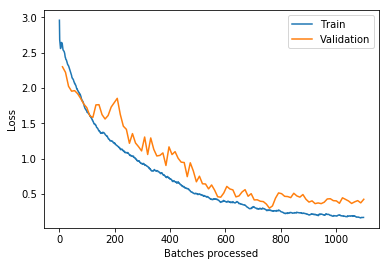

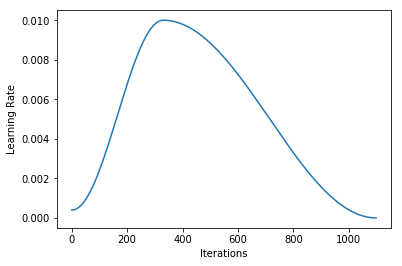

In [19]:
learn.recorder.plot_losses()
learn.recorder.plot_lr()

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


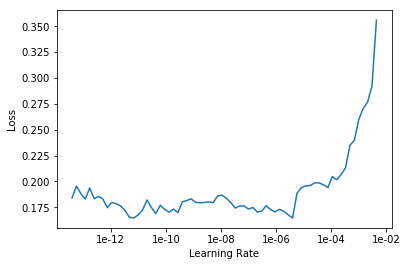

In [22]:
learn.lr_find(start_lr=1e-15)
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(50,slice(1e-08,(lr/10)))

epoch,train_loss,valid_loss,accuracy,error_rate,precision,recall,f_beta,matthews_correff,time
0,0.129766,0.403844,0.851064,0.148936,0.870000,0.866667,0.841349,0.838680,00:00
1,0.131885,0.401111,0.872340,0.127660,0.885000,0.886667,0.885833,0.860703,00:00
2,0.169702,0.368560,0.872340,0.127660,0.885000,0.886667,0.885833,0.860703,00:00
3,0.186626,0.394063,0.872340,0.127660,0.885000,0.886667,0.885833,0.860703,00:00
4,0.197428,0.400764,0.872340,0.127660,0.885000,0.886667,0.885833,0.860703,00:01
5,0.197257,0.386282,0.851064,0.148936,0.870000,0.866667,0.868330,0.838680,00:00
6,0.202681,0.371660,0.851064,0.148936,0.870000,0.866667,0.868330,0.838680,00:00
7,0.198218,0.375685,0.872340,0.127660,0.898333,0.886667,0.892462,0.862461,00:00
8,0.176940,0.376394,0.872340,0.127660,0.898333,0.886667,0.892462,0.862461,00:00
9,0.182252,0.359504,0.893617,0.106383,0.913333,0.906667,0.909988,0.884481,00:01


/usr/local/lib/python3.6/dist-packages/fastai/metrics.py:186: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


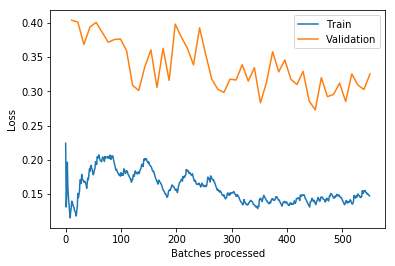

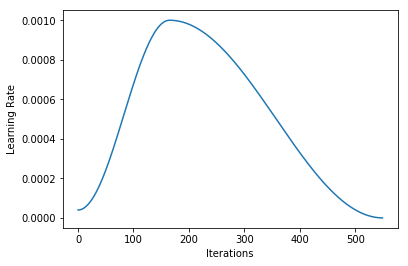

In [24]:
learn.recorder.plot_losses()
learn.recorder.plot_lr()

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

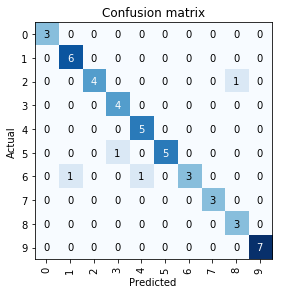

In [26]:
interp.plot_confusion_matrix()

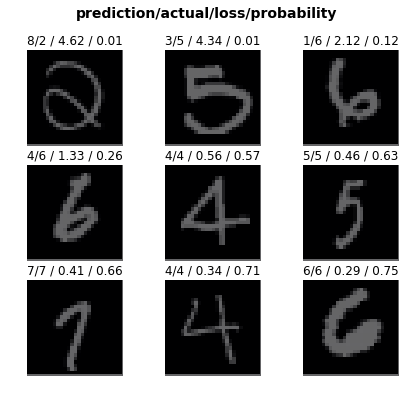

In [27]:
interp.plot_top_losses(9, figsize=(7,6))

In [0]:
learn.save(base_dir+'vgg_16_bn_onfido')

In [31]:
classes = [str(i) for i in range(0,10)]
data2 = ImageDataBunch.single_from_classes(path/'training', classes, ds_tfms=tfms, size=24).normalize(imagenet_stats)
learn2 = cnn_learner(data2, models.vgg16_bn)
learn2.load(base_dir+'vgg_16_bn_onfido')

Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /root/.fastai/data/mnist_png/training;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /root/.fastai/data/mnist_png/training;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace)
      (10): Conv2d(128, 12

In [32]:
img = data.valid_ds[30][0]
img

In [33]:
pred_class, pred_idx, outputs = learn.predict(img)
sorted(zip(learn2.data.classes, map(float,outputs)), key = lambda p : p[1], reverse = True)

[('9', 0.9733707308769226),
 ('8', 0.013142290525138378),
 ('2', 0.008157921954989433),
 ('4', 0.0025867847725749016),
 ('0', 0.0009880538564175367),
 ('7', 0.0009005336323752999),
 ('3', 0.0005666469223797321),
 ('1', 0.0002395543415332213),
 ('6', 2.854492049664259e-05),
 ('5', 1.8936007109005004e-05)]